In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from collections import defaultdict
# from textwrap import wrap

# Misc.
import warnings
warnings.filterwarnings('ignore')

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
from transformers import InputExample, InputFeatures
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer, util

torch.manual_seed(42)

2023-09-11 19:08:13.393803: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load dataset

In [2]:
df = pd.read_csv('/Users/twoon/Downloads/TrainDataACHReversal_modified_2023-8-1_1752.csv')
df.columns = list(df.columns.str.lower())
df.rename(columns={'is_chb': 'unauth'} , inplace = True)
df.head(5)

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,unauth
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1


In [3]:
df['short_desc'] = df['description'].apply(lambda x: 
                                             x if len(x) <= 30 else 
                                             (x[:30] if x[30]==' ' else 
                                              (x[:x[30:].index(' ') + 30] if ' ' in x[30:] else x)
                                             )
                                            )                                        

In [5]:
df.shape

(15746, 11)

# Training

In [4]:
# create training data
df_train = df[df['bank_name']!='Chime Bank']
df_train = df_train[['description', 'short_desc', 'bank_name', 'unauth']][0:5000] 

### BERT

#### Encode (Tokenize) description

In [5]:
# define tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', truncation = True)
model = BertModel.from_pretrained("bert-base-uncased", output_hidden_states = True)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
df_train['encode_bert']=df_train['short_desc'].apply(lambda x: tokenizer.encode(x, 
                                                                                truncation = True,
                                                                                max_length=512,
                                                                                return_tensors='pt'))

In [7]:
with torch.no_grad():
    result = model(df_train['encode_bert'].iloc[0])[0]

In [11]:
result.mean(axis=1).size()

torch.Size([1, 768])

In [7]:
with torch.no_grad():
    df_train['emb_bert'] = df_train['encode_bert'].apply(lambda x: model(x)[0])

In [35]:
# Define Chargeback Text
text = 'ACH DISPUTE' + '[SEP]' + 'Adjustment - Cr' + '[SEP]' + 'Misc. Credit Adjustment on ' + 'ACH Claim#' + '[SEP]' + 'Reversal'

encode_text = tokenizer.encode(text, return_tensors='pt')
with torch.no_grad():
    emb_text = model(encode_text)[0]

emb_text_mean = emb_text.mean(axis=1)

In [36]:
# calculate cosine similarity
df_train['similarity_bert'] = df_train['emb_bert'].apply(lambda x: torch.cosine_similarity(emb_text_mean, x.mean(axis=1)))
df_train['similarity_bert'] = df_train['similarity_bert'].astype('float32')

Minimum cosine similarity between the comparison text and unauthorized description : 0.474


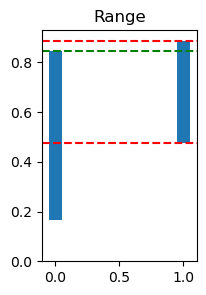

In [37]:
min_val = [df_train[df_train['unauth'] == 0]['similarity_bert'].min(), df_train[df_train['unauth'] == 1]['similarity_bert'].min()]
max_val = [df_train[df_train['unauth'] == 0]['similarity_bert'].max(), df_train[df_train['unauth'] == 1]['similarity_bert'].max()]

x = np.arange(2)

fig = plt.figure(figsize = (2, 3))

plt.bar(x, max_val, 0.1)
plt.bar(x, min_val, 0.1, color='white')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_bert'].min(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_bert'].max(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 0]['similarity_bert'].max(), color='g', linestyle='--')
plt.title('Range')

minimum = round(df_train[df_train['unauth'] == 1]['similarity_bert'].min(),3)

print(f'Minimum cosine similarity between the comparison text and unauthorized description : {minimum}')
    

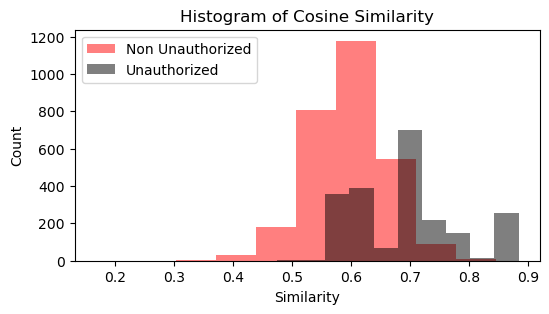

In [38]:
plt.figure(figsize = (6,3))

# histogram of cosine similarity
plt.hist(df_train[df_train['unauth'] == 0]['similarity_bert'], label = 'Non Unauthorized', fc = (1, 0, 0, 0.5))
plt.hist(df_train[df_train['unauth'] == 1]['similarity_bert'], label = 'Unauthorized', fc=(0, 0, 0, 0.5))
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.title(f'Histogram of Cosine Similarity')
plt.legend()
plt.show()

In [44]:
threshold = 0.695
unauth = df_train[(df_train['unauth'] == 1) & (df_train['similarity_bert'] > threshold)].short_desc.count()
total_unauth = df_train[(df_train['unauth'] == 1)].short_desc.count()

fp_unauth = df_train[(df_train['unauth'] == 0) & (df_train['similarity_bert'] > threshold)].short_desc.count()
total_not_unauth = df_train[(df_train['unauth'] == 0)].short_desc.count()

print(f'Number of unauthorized transactions above {threshold} : {unauth}')
print(f'Poportion in terms of total unauthorized transactions : {round(unauth*100/total_unauth,2)}% \n')
print(f'Number of non unauthorized transactions above {threshold} : {fp_unauth}')
print(f'Poportion in terms of total non unauthorized transactions (False Positive Rate) : {round(fp_unauth*100/total_not_unauth,2)}%')

Number of unauthorized transactions above 0.695 : 1322
Poportion in terms of total unauthorized transactions : 61.37% 

Number of non unauthorized transactions above 0.695 : 155
Poportion in terms of total non unauthorized transactions (False Positive Rate) : 5.45%


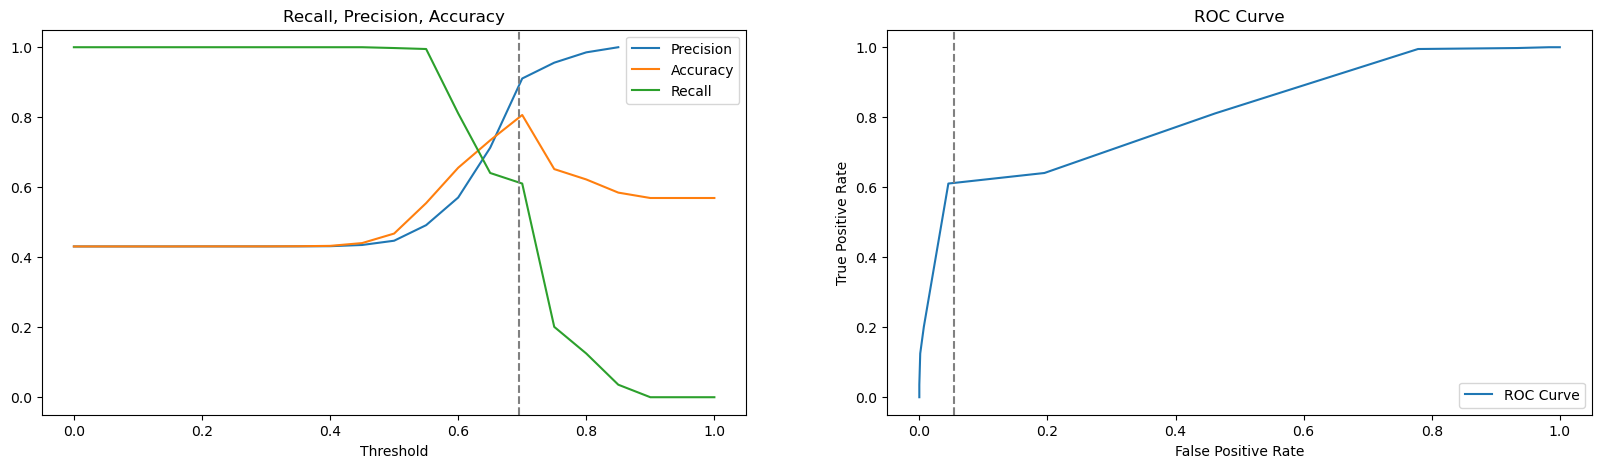

Threshold : 0.695
Recall : 0.61
Precision : 0.9
Accuracy : 0.8


In [114]:
# calculate true positive rate, false positive rate and precision
x = np.arange(21)*0.05
fpr = []
precision = []
accuracy = []
recall = []

for i in x:
    threshold = i

    tp = df_train[(df_train['unauth'] == 1) & (df_train['similarity_bert'] > threshold)].short_desc.count()
    total_positive = df_train[(df_train['unauth'] == 1)].short_desc.count() # TP + FN
    recall.append(tp/total_positive)
    
    fp = df_train[(df_train['unauth'] == 0) & (df_train['similarity_bert'] > threshold)].short_desc.count()
    total_negative = df_train[(df_train['unauth'] == 0)].short_desc.count() # FP + TN
    fpr.append(fp/total_negative)

    precision.append(tp/(tp+fp))
    
    tn = df_train[(df_train['unauth'] == 0) & (df_train['similarity_bert'] < threshold)].short_desc.count()
    total = df_train.short_desc.count()
    accuracy.append((tp+tn)/total)
    

# plot curves
figs, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(x, precision, label='Precision')
axs[0].plot(x, accuracy, label='Accuracy')
axs[0].plot(x, recall, label='Recall')
axs[0].set_xlabel('Threshold')
axs[0].set_title('Recall, Precision, Accuracy')
axs[0].legend()

axs[1].plot(fpr, recall, label='ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend()

threshold = 0.695

tp = df_train[(df_train['unauth']==1) & (df_train['similarity_bert']>threshold)].short_desc.count()
fp = df_train[(df_train['unauth']==0) & (df_train['similarity_bert']>threshold)].short_desc.count()
tn = df_train[(df_train['unauth']==0) & (df_train['similarity_bert']<threshold)].short_desc.count()
fn = df_train[(df_train['unauth']==1) & (df_train['similarity_bert']<threshold)].short_desc.count()

axs[0].axvline(x=threshold, color='gray', linestyle='--')
axs[1].axvline(x=fp/(fp+tn), color='gray', linestyle='--')

plt.show()

print(f'Threshold : {threshold}')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}') 
print(f'Accuracy : {round((tp+tn)/(tp+fp+tn+fn),2)}')

### Sentence Transformer

#### all-MiniLM-L6-v2

In [68]:
model_sen = SentenceTransformer('all-MiniLM-L6-v2')

In [83]:
df_train['emb_sen']=df_train['short_desc'].apply(lambda x: model_sen.encode(x))

In [84]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_sen.encode(text)

df_train['similarity_sen'] = df_train['emb_sen'].apply(lambda x: util.cos_sim(x,text_emb))
df_train['similarity_sen'] = df_train['similarity_sen'].astype('float32')

Minimum cosine similarity between the comparison text and unauthorized description : 0.023


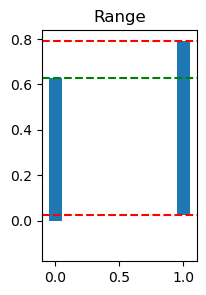

In [85]:
min_val = [df_train[df_train['unauth'] == 0]['similarity_sen'].min(), df_train[df_train['unauth'] == 1]['similarity_sen'].min()]
max_val = [df_train[df_train['unauth'] == 0]['similarity_sen'].max(), df_train[df_train['unauth'] == 1]['similarity_sen'].max()]

x = np.arange(2)

fig = plt.figure(figsize = (2, 3))

plt.bar(x, max_val, 0.1)
plt.bar(x, min_val, 0.1, color='white')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_sen'].min(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_sen'].max(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 0]['similarity_sen'].max(), color='g', linestyle='--')
plt.title('Range')

minimum = round(df_train[df_train['unauth'] == 1]['similarity_sen'].min(),3)

print(f'Minimum cosine similarity between the comparison text and unauthorized description : {minimum}')
    

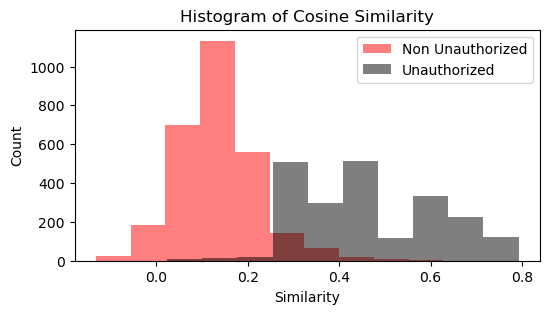

In [86]:
plt.figure(figsize = (6,3))

# histogram of cosine similarity
plt.hist(df_train[df_train['unauth'] == 0]['similarity_sen'], label = 'Non Unauthorized', fc = (1, 0, 0, 0.5))
plt.hist(df_train[df_train['unauth'] == 1]['similarity_sen'], label = 'Unauthorized', fc=(0, 0, 0, 0.5))
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.title(f'Histogram of Cosine Similarity')
plt.legend()
plt.show()

In [87]:
threshold = 0.3
unauth = df_train[(df_train['unauth'] == 1) & (df_train['similarity_sen'] > threshold)].short_desc.count()
total_unauth = df_train[(df_train['unauth'] == 1)].short_desc.count()

fp_unauth = df_train[(df_train['unauth'] == 0) & (df_train['similarity_sen'] > threshold)].short_desc.count()
total_not_unauth = df_train[(df_train['unauth'] == 0)].short_desc.count()

print(f'Number of unauthorized transactions above {threshold} : {unauth}')
print(f'Poportion in terms of total unauthorized transactions : {round(unauth*100/total_unauth,2)}% \n')
print(f'Number of non unauthorized transactions above {threshold} : {fp_unauth}')
print(f'Poportion in terms of total non unauthorized transactions (False Positive Rate) : {round(fp_unauth*100/total_not_unauth,2)}%')

Number of unauthorized transactions above 0.3 : 1772
Poportion in terms of total unauthorized transactions : 82.27% 

Number of non unauthorized transactions above 0.3 : 145
Poportion in terms of total non unauthorized transactions (False Positive Rate) : 5.09%


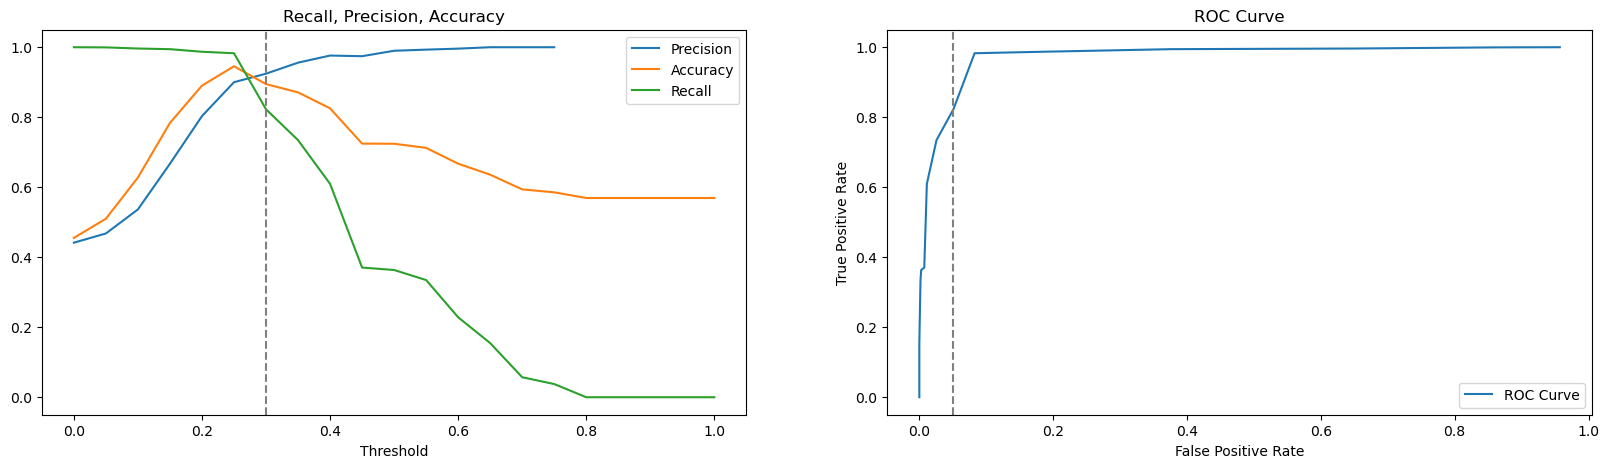

Threshold : 0.3
Recall : 0.82
Precision : 0.92
Accuracy : 0.89


In [111]:
# calculate true positive rate, false positive rate and precision
x = np.arange(21)*0.05
fpr = []
precision = []
accuracy = []
recall = []

for i in x:
    threshold = i

    tp = df_train[(df_train['unauth'] == 1) & (df_train['similarity_sen'] > threshold)].short_desc.count()
    total_positive = df_train[(df_train['unauth'] == 1)].short_desc.count() # TP + FN
    recall.append(tp/total_positive)
    
    fp = df_train[(df_train['unauth'] == 0) & (df_train['similarity_sen'] > threshold)].short_desc.count()
    total_negative = df_train[(df_train['unauth'] == 0)].short_desc.count() # FP + TN
    fpr.append(fp/total_negative)

    precision.append(tp/(tp+fp))
    
    tn = df_train[(df_train['unauth'] == 0) & (df_train['similarity_sen'] < threshold)].short_desc.count()
    total = df_train.short_desc.count()
    accuracy.append((tp+tn)/total)
    

# plot curves
figs, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(x, precision, label='Precision')
axs[0].plot(x, accuracy, label='Accuracy')
axs[0].plot(x, recall, label='Recall')
axs[0].set_xlabel('Threshold')
axs[0].set_title('Recall, Precision, Accuracy')
axs[0].legend()

axs[1].plot(fpr, recall, label='ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend()

threshold = 0.3

tp = df_train[(df_train['unauth']==1) & (df_train['similarity_sen']>threshold)].short_desc.count()
fp = df_train[(df_train['unauth']==0) & (df_train['similarity_sen']>threshold)].short_desc.count()
tn = df_train[(df_train['unauth']==0) & (df_train['similarity_sen']<threshold)].short_desc.count()
fn = df_train[(df_train['unauth']==1) & (df_train['similarity_sen']<threshold)].short_desc.count()

axs[0].axvline(x=threshold, color='gray', linestyle='--')
axs[1].axvline(x=fp/(fp+tn), color='gray', linestyle='--')

plt.show()

print(f'Threshold : {threshold}')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}') 
print(f'Accuracy : {round((tp+tn)/(tp+fp+tn+fn),2)}')

#### multi-qa-mpnet-base-dot-v1

In [92]:
model_search = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [93]:
df_train['emb_search']=df_train['short_desc'].apply(lambda x: model_search.encode(x))

In [94]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_search.encode(text)

df_train['similarity_search'] = df_train['emb_search'].apply(lambda x: util.dot_score(x,text_emb))
df_train['similarity_search'] = df_train['similarity_search'].astype('float32')

Minimum cosine similarity between the comparison text and unauthorized description : 9.956


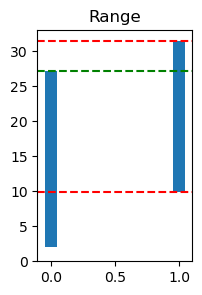

In [95]:
min_val = [df_train[df_train['unauth'] == 0]['similarity_search'].min(), df_train[df_train['unauth'] == 1]['similarity_search'].min()]
max_val = [df_train[df_train['unauth'] == 0]['similarity_search'].max(), df_train[df_train['unauth'] == 1]['similarity_search'].max()]

x = np.arange(2)

fig = plt.figure(figsize = (2, 3))

plt.bar(x, max_val, 0.1)
plt.bar(x, min_val, 0.1, color='white')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_search'].min(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 1]['similarity_search'].max(), color='r', linestyle='--')
plt.axhline(y=df_train[df_train['unauth'] == 0]['similarity_search'].max(), color='g', linestyle='--')
plt.title('Range')

minimum = round(df_train[df_train['unauth'] == 1]['similarity_search'].min(),3)

print(f'Minimum cosine similarity between the comparison text and unauthorized description : {minimum}')
    

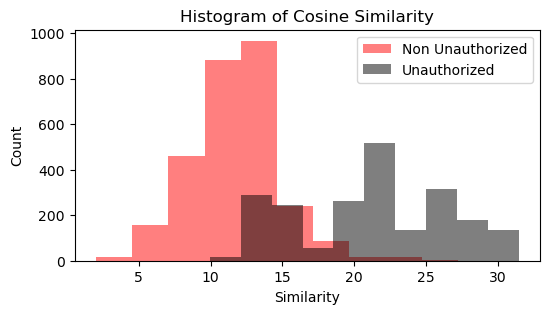

In [96]:
plt.figure(figsize = (6,3))

# histogram of cosine similarity
plt.hist(df_train[df_train['unauth'] == 0]['similarity_search'], label = 'Non Unauthorized', fc = (1, 0, 0, 0.5))
plt.hist(df_train[df_train['unauth'] == 1]['similarity_search'], label = 'Unauthorized', fc=(0, 0, 0, 0.5))
plt.xlabel('Similarity')
plt.ylabel('Count')
plt.title(f'Histogram of Cosine Similarity')
plt.legend()
plt.show()

In [97]:
threshold = 16.5
unauth = df_train[(df_train['unauth'] == 1) & (df_train['similarity_search'] > threshold)].short_desc.count()
total_unauth = df_train[(df_train['unauth'] == 1)].short_desc.count()

fp_unauth = df_train[(df_train['unauth'] == 0) & (df_train['similarity_search'] > threshold)].short_desc.count()
total_not_unauth = df_train[(df_train['unauth'] == 0)].short_desc.count()

print(f'Number of unauthorized transactions above {threshold} : {unauth}')
print(f'Poportion in terms of total unauthorized transactions : {round(unauth*100/total_unauth,2)}% \n')
print(f'Number of non unauthorized transactions above {threshold} : {fp_unauth}')
print(f'Poportion in terms of total non unauthorized transactions (False Positive Rate) : {round(fp_unauth*100/total_not_unauth,2)}%')

Number of unauthorized transactions above 16.5 : 1603
Poportion in terms of total unauthorized transactions : 74.42% 

Number of non unauthorized transactions above 16.5 : 162
Poportion in terms of total non unauthorized transactions (False Positive Rate) : 5.69%


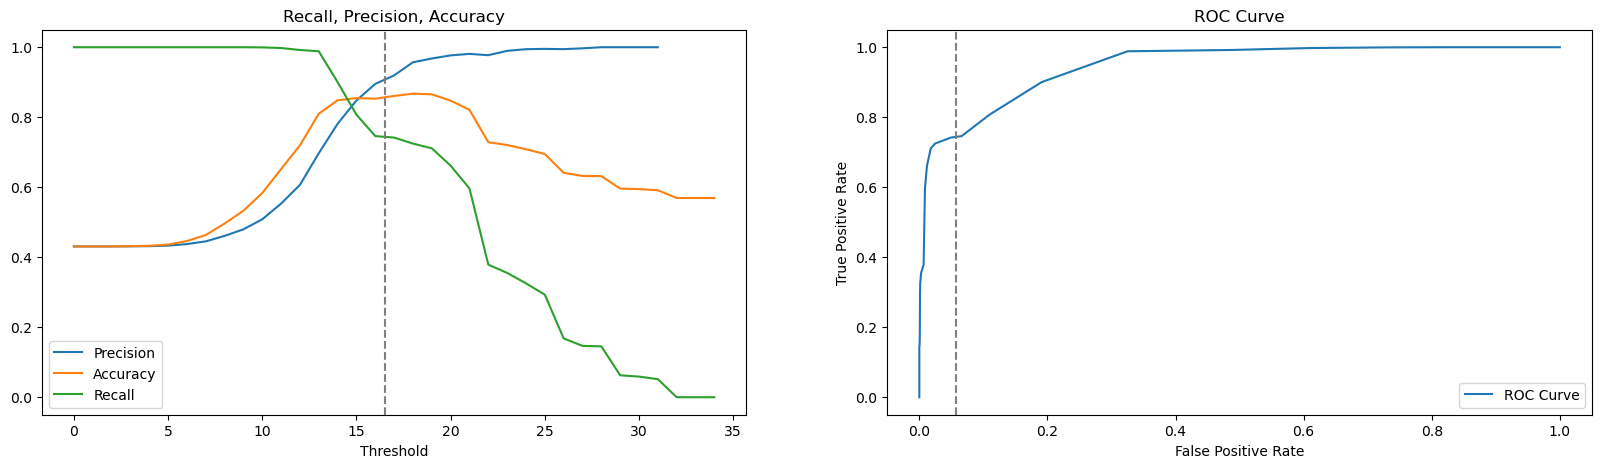

Threshold : 16.5
Recall : 0.74
Precision : 0.91
Accuracy : 0.86


In [113]:
# calculate true positive rate, false positive rate and precision
x = np.arange(35)
fpr = []
precision = []
accuracy = []
recall = []

for i in x:
    threshold = i

    tp = df_train[(df_train['unauth'] == 1) & (df_train['similarity_search'] > threshold)].short_desc.count()
    total_positive = df_train[(df_train['unauth'] == 1)].short_desc.count() # TP + FN
    recall.append(tp/total_positive)
    
    fp = df_train[(df_train['unauth'] == 0) & (df_train['similarity_search'] > threshold)].short_desc.count()
    total_negative = df_train[(df_train['unauth'] == 0)].short_desc.count() # FP + TN
    fpr.append(fp/total_negative)

    precision.append(tp/(tp+fp))
    
    tn = df_train[(df_train['unauth'] == 0) & (df_train['similarity_search'] < threshold)].short_desc.count()
    total = df_train.short_desc.count()
    accuracy.append((tp+tn)/total)
    

# plot curves
figs, axs = plt.subplots(1, 2, figsize=(20, 5))

axs[0].plot(x, precision, label='Precision')
axs[0].plot(x, accuracy, label='Accuracy')
axs[0].plot(x, recall, label='Recall')
axs[0].set_xlabel('Threshold')
axs[0].set_title('Recall, Precision, Accuracy')
axs[0].legend()

axs[1].plot(fpr, recall, label='ROC Curve')
axs[1].set_xlabel('False Positive Rate')
axs[1].set_ylabel('True Positive Rate')
axs[1].set_title('ROC Curve')
axs[1].legend()

threshold = 16.5

tp = df_train[(df_train['unauth']==1) & (df_train['similarity_search']>threshold)].short_desc.count()
fp = df_train[(df_train['unauth']==0) & (df_train['similarity_search']>threshold)].short_desc.count()
tn = df_train[(df_train['unauth']==0) & (df_train['similarity_search']<threshold)].short_desc.count()
fn = df_train[(df_train['unauth']==1) & (df_train['similarity_search']<threshold)].short_desc.count()

axs[0].axvline(x=threshold, color='gray', linestyle='--')
axs[1].axvline(x=fp/(fp+tn), color='gray', linestyle='--')

plt.show()

print(f'Threshold : {threshold}')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}') 
print(f'Accuracy : {round((tp+tn)/(tp+fp+tn+fn),2)}')

# Testing

In [115]:
# create testing data without Chime Bank
df_test = df[df['bank_name']!='Chime Bank']
df_test = df_test[['description', 'short_desc', 'bank_name', 'unauth']][5000:] 

## BERT

In [117]:
df_test['encode_bert']=df_test['short_desc'].apply(lambda x: tokenizer.encode(x, 
                                                                              truncation = True,
                                                                              max_length=512,
                                                                              return_tensors='pt'))

In [118]:
with torch.no_grad():
    df_test['emb_bert'] = df_test['encode_bert'].apply(lambda x: model(x)[0])

In [199]:
# Define Chargeback Text
text = 'ACH DISPUTE' + '[SEP]' + 'Adjustment - Cr ' + '[SEP]' + 'Misc. Credit Adjustment on ' + 'ACH Claim#' + '[SEP]' + 'Reversal'

encode_text = tokenizer.encode(text, return_tensors='pt')
with torch.no_grad():
    emb_text = model(encode_text)[0]

emb_text_mean = emb_text.mean(axis=1)

In [200]:
# calculate cosine similarity
df_test['similarity_bert'] = df_test['emb_bert'].apply(lambda x: torch.cosine_similarity(emb_text_mean, x.mean(axis=1)))
df_test['similarity_bert'] = df_test['similarity_bert'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_bert = 0.695
df_test['pred_bert'] = df_test['similarity_bert'].apply(lambda x: 1 if x>= threshold_bert else 0)

In [202]:
# evaluate
tp = df_test[(df_test['unauth']==1) & (df_test['pred_bert']==1)].count()[0]
fp = df_test[(df_test['unauth']==0) & (df_test['pred_bert']==1)].count()[0]
tn = df_test[(df_test['unauth']==0) & (df_test['pred_bert']==0)].count()[0]
fn = df_test[(df_test['unauth']==1) & (df_test['pred_bert']==0)].count()[0]

print(f'BERT Model Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

BERT Model Prediction:
Recall : 0.62
Precision : 0.88
Accuracy : 0.8


## Sentence Transformer : all-MiniLM-L6-v2

In [122]:
df_test['emb_sen']=df_test['short_desc'].apply(lambda x: model_sen.encode(x))

In [124]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_sen.encode(text)

df_test['similarity_sen'] = df_test['emb_sen'].apply(lambda x: util.cos_sim(x,text_emb))
df_test['similarity_sen'] = df_test['similarity_sen'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_sen = 0.3
df_test['pred_sen'] = df_test['similarity_sen'].apply(lambda x: 1 if x>= threshold_sen else 0)

In [217]:
#evaluate
tp = df_test[(df_test['unauth']==1) & (df_test['pred_sen']==1)].count()[0]
fp = df_test[(df_test['unauth']==0) & (df_test['pred_sen']==1)].count()[0]
tn = df_test[(df_test['unauth']==0) & (df_test['pred_sen']==0)].count()[0]
fn = df_test[(df_test['unauth']==1) & (df_test['pred_sen']==0)].count()[0]

print(f'Sentence Transformer - all-MiniLM-L6-v2 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - all-MiniLM-L6-v2 - Prediction:
Recall : 0.83
Precision : 0.93
Accuracy : 0.9


## Sentence Transformer : multi-qa-mpnet-base-dot-v1

In [126]:
df_test['emb_search']=df_test['short_desc'].apply(lambda x: model_search.encode(x))

In [210]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_search.encode(text)

df_test['similarity_search'] = df_test['emb_search'].apply(lambda x: util.dot_score(x,text_emb))
df_test['similarity_search'] = df_test['similarity_search'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_search = 16.5
df_test['pred_search'] = df_test['similarity_search'].apply(lambda x: 1 if x>= threshold_search else 0)

In [218]:
#evaluate
tp = df_test[(df_test['unauth']==1) & (df_test['pred_search']==1)].count()[0]
fp = df_test[(df_test['unauth']==0) & (df_test['pred_search']==1)].count()[0]
tn = df_test[(df_test['unauth']==0) & (df_test['pred_search']==0)].count()[0]
fn = df_test[(df_test['unauth']==1) & (df_test['pred_search']==0)].count()[0]

print(f'Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:
Recall : 0.76
Precision : 0.91
Accuracy : 0.86


#### BERT

## Testing Data for Chime Bank

In [145]:
# create testing data without Chime Bank
df_chime = df[df['bank_name'] == 'Chime Bank'][['description', 'short_desc', 'bank_name', 'unauth']]

### BERT Model

In [146]:
df_chime['encode_bert']=df_chime['short_desc'].apply(lambda x: tokenizer.encode(x, 
                                                                                truncation = True,
                                                                                max_length=512,
                                                                                return_tensors='pt'))

In [147]:
with torch.no_grad():
    df_chime['emb_bert'] = df_chime['encode_bert'].apply(lambda x: model(x)[0])

In [212]:
# Define Chargeback Text
text = 'ACH DISPUTE' + '[SEP]' + 'Adjustment - Cr ' + '[SEP]' + 'Misc. Credit Adjustment on ' + 'ACH Claim#' + '[SEP]' + 'Reversal'

encode_text = tokenizer.encode(text, return_tensors='pt')
with torch.no_grad():
    emb_text = model(encode_text)[0]

emb_text_mean = emb_text.mean(axis=1)

In [213]:
# calculate cosine similarity
df_chime['similarity_bert'] = df_chime['emb_bert'].apply(lambda x: torch.cosine_similarity(emb_text_mean, x.mean(axis=1)))
df_chime['similarity_bert'] = df_chime['similarity_bert'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_bert = 0.695
df_chime['pred_bert'] = df_chime['similarity_bert'].apply(lambda x: 1 if x>= threshold_bert else 0)

In [222]:
# evaluate
tp = df_chime[(df_chime['unauth']==1) & (df_chime['pred_bert']==1)].count()[0]
fp = df_chime[(df_chime['unauth']==0) & (df_chime['pred_bert']==1)].count()[0]
tn = df_chime[(df_chime['unauth']==0) & (df_chime['pred_bert']==0)].count()[0]
fn = df_chime[(df_chime['unauth']==1) & (df_chime['pred_bert']==0)].count()[0]

print(f'BERT Model Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

BERT Model Prediction:
Recall : 0.2
Precision : 0.85
Accuracy : 0.47


### Sentence Transformer : all-MiniLM-L6-v2

In [150]:
df_chime['emb_sen']=df_chime['short_desc'].apply(lambda x: model_sen.encode(x))

In [151]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_sen.encode(text)

df_chime['similarity_sen'] = df_chime['emb_sen'].apply(lambda x: util.cos_sim(x,text_emb))
df_chime['similarity_sen'] = df_chime['similarity_sen'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_sen = 0.3
df_chime['pred_sen'] = df_chime['similarity_sen'].apply(lambda x: 1 if x>= threshold_sen else 0)

In [248]:
# evaluate
tp = df_chime[(df_chime['unauth']==1) & (df_chime['pred_sen']==1)].count()[0]
fp = df_chime[(df_chime['unauth']==0) & (df_chime['pred_sen']==1)].count()[0]
tn = df_chime[(df_chime['unauth']==0) & (df_chime['pred_sen']==0)].count()[0]
fn = df_chime[(df_chime['unauth']==1) & (df_chime['pred_sen']==0)].count()[0]

print(f'Sentence Transformer - all-MiniLM-L6-v2 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),5)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - all-MiniLM-L6-v2 - Prediction:
Recall : 0.00165
Precision : 0.05
Accuracy : 0.34


### Sentence Transformer : multi-qa-mpnet-base-dot-v1

In [152]:
df_chime['emb_search']=df_chime['short_desc'].apply(lambda x: model_search.encode(x))

In [216]:
# calculate cosine similarity
text = 'ACH DISPUTE ' + 'Adjustment - Cr ' + 'Misc. Credit Adjustment on ' + 'ACH Claim# ' + 'Reversal'
text_emb = model_search.encode(text)

df_chime['similarity_search'] = df_chime['emb_search'].apply(lambda x: util.dot_score(x,text_emb))
df_chime['similarity_search'] = df_chime['similarity_search'].astype('float32')

# make prediction ; 1 = chargeback/unauth , 0 = good transaction
threshold_search = 16.5
df_chime['pred_search'] = df_chime['similarity_search'].apply(lambda x: 1 if x>= threshold_search else 0)

In [249]:
# evaluate
tp = df_chime[(df_chime['unauth']==1) & (df_chime['pred_search']==1)].count()[0]
fp = df_chime[(df_chime['unauth']==0) & (df_chime['pred_search']==1)].count()[0]
tn = df_chime[(df_chime['unauth']==0) & (df_chime['pred_search']==0)].count()[0]
fn = df_chime[(df_chime['unauth']==1) & (df_chime['pred_search']==0)].count()[0]

print(f'Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),5)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:
Recall : 0.00331
Precision : 0.08
Accuracy : 0.34


## Overall (include Chime)

In [166]:
df_test_all = pd.concat([df_test, df_chime])

In [167]:
tp = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_bert']==1)].count()[0]
fp = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_bert']==1)].count()[0]
tn = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_bert']==0)].count()[0]
fn = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_bert']==0)].count()[0]

print(f'BERT Model Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

BERT Model Prediction:
Recall : 0.4
Precision : 0.87
Accuracy : 0.66


In [226]:
tp = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_sen']==1)].count()[0]
fp = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_sen']==1)].count()[0]
tn = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_sen']==0)].count()[0]
fn = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_sen']==0)].count()[0]

print(f'Sentence Transformer - all-MiniLM-L6-v2 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - all-MiniLM-L6-v2 - Prediction:
Recall : 0.38
Precision : 0.89
Accuracy : 0.65


In [228]:
tp = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_search']==1)].count()[0]
fp = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_search']==1)].count()[0]
tn = df_test_all[(df_test_all['unauth']==0) & (df_test_all['pred_search']==0)].count()[0]
fn = df_test_all[(df_test_all['unauth']==1) & (df_test_all['pred_search']==0)].count()[0]

print(f'Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)}')

Sentence Transformer - multi-qa-mpnet-base-dot-v1 - Prediction:
Recall : 0.35
Precision : 0.87
Accuracy : 0.63


## Regex

In [6]:
import re

In [7]:
def regex_match(bank, text):
    if bank == 'Chase' and re.match(r'^(Reversal:) .+', text):
        return True
    elif bank == 'Bank of America' and re.match(r'(^(Misc. Credit Adjustment on) [0-9]{2}\/[0-9]{2}\/[0-9]{2} (Card|Acct) # [X0-9]+ Claim # X{5}[0-9]{7}|^(ACH (Temporary )?Credit Adjustment on) [0-9]{2}\/[0-9]{2}\/[0-9]{2} Acct # X{5}[0-9]{7} Claim # X{5}[0-9]{7}|^(Temporary Credit Adjustment on) [0-9]{2}\/[0-9]{2}\/[0-9]{2} Card # X{10}[0-9]{6} Claim # X{5}[0-9]{7})', text):
        return True
    elif bank == 'Wells Fargo' and re.match(r'(^(CARD (CLAIM )?FINAL CREDIT) [0-9]+|^(ACH Claim#).?[0-9]{13}|^(INSTACASH PAYMEN HIST RTN) .+)', text):
        return True
    elif bank == 'Chime Bank' and re.match(r'((Direct Debit: )?([0-9]+ )?Direct Debit Instacash Payme(n)?( Moneylion)?( .+)?|^(Unauth Debit Wsud)$)', text):
        return True
    elif bank == 'Navy Federal Credit Union' and re.match(r'(^(Adjustment - Cr)(edit)?|(Check )?Reversal)', text):
        return True
    elif bank == 'USAA' and re.match(r'^(ACH DISPUTE CR)$', text):
        return True
    elif bank == 'Capital One' and re.match('^(Withdrawal Reversal)$', text):
        return True
    elif bank == 'PNC' and re.match('^(ACH DISPUTE CREDIT)$', text):
        return True
    elif bank == 'Huntington Bank' and re.match('^(Dispute Final Credit)$', text):
        return True
    elif bank == 'US Bank' and re.match('^(98achi00)[0-9]{11} [0-9]{2}\/[0-9]{2}\/[0-9]{4} (Ach Adjustment)$', text):
        return True
    elif bank == 'Regions Bank' and re.match('^(Regions Bank Reg E Adjustment)$', text):
        return True
    else:
        return False                          

In [8]:
df_regex = df
df_regex['regex_match'] = df_regex.apply(lambda df: regex_match(df['bank_name'], df['description']), axis=1)
df_regex.head(5)

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,unauth,short_desc,regex_match
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1,Direct Debit: 4250411835 Direct,True
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1,Reversal: INSTACASH PAYMEN MONEYLION,True
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1,Dispute Final Credit,True
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1,INSTACASH PAYMEN REVERSAL,False
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1,INSTACASH PAYMEN,False


In [9]:
df_regex_train = df_regex[df_regex['bank_name']!='Chime Bank'][:5000]
df_regex_test = df_regex[df_regex['bank_name']!='Chime Bank'][5000:]
df_regex_chime = df_regex[df_regex['bank_name']=='Chime Bank']
df_regex_test_all = pd.concat([df_regex_test,df_regex_chime])

In [12]:
# train data
tp = df_regex_train[(df_regex_train['unauth']==1) & (df_regex_train['regex_match']==True)].count()[0]
fp = df_regex_train[(df_regex_train['unauth']==0) & (df_regex_train['regex_match']==True)].count()[0]
tn = df_regex_train[(df_regex_train['unauth']==0) & (df_regex_train['regex_match']==False)].count()[0]
fn = df_regex_train[(df_regex_train['unauth']==1) & (df_regex_train['regex_match']==False)].count()[0]

print(f'Regex on Train Data:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {tp/(tp+fp)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# test data exclude Chime Bank
tp = df_regex_test[(df_regex_test['unauth']==1) & (df_regex_test['regex_match']==True)].count()[0]
fp = df_regex_test[(df_regex_test['unauth']==0) & (df_regex_test['regex_match']==True)].count()[0]
tn = df_regex_test[(df_regex_test['unauth']==0) & (df_regex_test['regex_match']==False)].count()[0]
fn = df_regex_test[(df_regex_test['unauth']==1) & (df_regex_test['regex_match']==False)].count()[0]

print(f'Regex on Test Data excl Chime Bank:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {tp/(tp+fp)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# chime bank
tp = df_regex_chime[(df_regex_chime['unauth']==1) & (df_regex_chime['regex_match']==True)].count()[0]
fp = df_regex_chime[(df_regex_chime['unauth']==0) & (df_regex_chime['regex_match']==True)].count()[0]
tn = df_regex_chime[(df_regex_chime['unauth']==0) & (df_regex_chime['regex_match']==False)].count()[0]
fn = df_regex_chime[(df_regex_chime['unauth']==1) & (df_regex_chime['regex_match']==False)].count()[0]

print(f'Regex on Chime Bank:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {tp/(tp+fp)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# overall test data 
tp = df_regex_test_all[(df_regex_test_all['unauth']==1) & (df_regex_test_all['regex_match']==True)].count()[0]
fp = df_regex_test_all[(df_regex_test_all['unauth']==0) & (df_regex_test_all['regex_match']==True)].count()[0]
tn = df_regex_test_all[(df_regex_test_all['unauth']==0) & (df_regex_test_all['regex_match']==False)].count()[0]
fn = df_regex_test_all[(df_regex_test_all['unauth']==1) & (df_regex_test_all['regex_match']==False)].count()[0]

print(f'Regex on Overall Test Data:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {tp/(tp+fp)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

Regex on Train Data:
Recall : 0.79
Precision : 0.9994152046783625
Accuracy : 0.91 

Regex on Test Data excl Chime Bank:
Recall : 0.78
Precision : 0.9990094105993066
Accuracy : 0.91 

Regex on Chime Bank:
Recall : 0.98
Precision : 1.0
Accuracy : 0.98 

Regex on Overall Test Data:
Recall : 0.89
Precision : 0.999597423510467
Accuracy : 0.94 



In [11]:
# train data
tp = df_regex_train[(df_regex_train['unauth']==1) & (df_regex_train['regex_match']==True)].count()[0]
fp = df_regex_train[(df_regex_train['unauth']==0) & (df_regex_train['regex_match']==True)].count()[0]
tn = df_regex_train[(df_regex_train['unauth']==0) & (df_regex_train['regex_match']==False)].count()[0]
fn = df_regex_train[(df_regex_train['unauth']==1) & (df_regex_train['regex_match']==False)].count()[0]

print(f'Regex on Train Data:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {tp/(tp+fp)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

Regex on Train Data:
Recall : 0.79
Precision : 0.9994152046783625
Accuracy : 0.91 



## All labels as Unauth

In [322]:
df_all_unauth = df
df_all_unauth['label_unauth'] = 1
df_all_unauth.head(5)

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,unauth,short_desc,regex_match,label_unauth
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1,Direct Debit: 4250411835 Direct,True,1
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1,Reversal: INSTACASH PAYMEN MONEYLION,True,1
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1,Dispute Final Credit,True,1
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1,INSTACASH PAYMEN REVERSAL,False,1
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1,INSTACASH PAYMEN,False,1


In [331]:
df_all_unauth_train = df_all_unauth[df_all_unauth['bank_name']!='Chime Bank'][:5000]
df_all_unauth_test = df_all_unauth[df_all_unauth['bank_name']!='Chime Bank'][5000:]
df_all_unauth_chime = df_all_unauth[df_all_unauth['bank_name']=='Chime Bank']
df_all_unauth_test_all = pd.concat([df_all_unauth_test,df_all_unauth_chime])

In [332]:
# train data
tp = df_all_unauth_train[(df_all_unauth_train['unauth']==1) & (df_all_unauth_train['label_unauth']==1)].count()[0]
fp = df_all_unauth_train[(df_all_unauth_train['unauth']==0) & (df_all_unauth_train['label_unauth']==1)].count()[0]
tn = df_all_unauth_train[(df_all_unauth_train['unauth']==0) & (df_all_unauth_train['label_unauth']==0)].count()[0]
fn = df_all_unauth_train[(df_all_unauth_train['unauth']==1) & (df_all_unauth_train['label_unauth']==0)].count()[0]

print(f'All Unauth on Train Data:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# test data exclude Chime Bank
tp = df_all_unauth_test[(df_all_unauth_test['unauth']==1) & (df_all_unauth_test['label_unauth']==1)].count()[0]
fp = df_all_unauth_test[(df_all_unauth_test['unauth']==0) & (df_all_unauth_test['label_unauth']==1)].count()[0]
tn = df_all_unauth_test[(df_all_unauth_test['unauth']==0) & (df_all_unauth_test['label_unauth']==0)].count()[0]
fn = df_all_unauth_test[(df_all_unauth_test['unauth']==1) & (df_all_unauth_test['label_unauth']==0)].count()[0]

print(f'All Unauth on Test Data excl Chime Bank:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# chime bank
tp = df_all_unauth_chime[(df_all_unauth_chime['unauth']==1) & (df_all_unauth_chime['label_unauth']==1)].count()[0]
fp = df_all_unauth_chime[(df_all_unauth_chime['unauth']==0) & (df_all_unauth_chime['label_unauth']==1)].count()[0]
tn = df_all_unauth_chime[(df_all_unauth_chime['unauth']==0) & (df_all_unauth_chime['label_unauth']==0)].count()[0]
fn = df_all_unauth_chime[(df_all_unauth_chime['unauth']==1) & (df_all_unauth_chime['label_unauth']==0)].count()[0]

print(f'All Unauth on Chime Bank:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

# overall test data 
tp = df_all_unauth_test_all[(df_all_unauth_test_all['unauth']==1) & (df_all_unauth_test_all['label_unauth']==1)].count()[0]
fp = df_all_unauth_test_all[(df_all_unauth_test_all['unauth']==0) & (df_all_unauth_test_all['label_unauth']==1)].count()[0]
tn = df_all_unauth_test_all[(df_all_unauth_test_all['unauth']==0) & (df_all_unauth_test_all['label_unauth']==0)].count()[0]
fn = df_all_unauth_test_all[(df_all_unauth_test_all['unauth']==1) & (df_all_unauth_test_all['label_unauth']==0)].count()[0]

print(f'All Unauth on Overall Test Data:')
print(f'Recall : {round(tp/(tp+fn),2)}')
print(f'Precision : {round(tp/(tp+fp),2)}')
print(f'Accuracy : {round((tp+tn)/(tp+tn+fp+fn),2)} \n')

All Unauth on Train Data:
Recall : 1.0
Precision : 0.43
Accuracy : 0.43 

All Unauth on Test Data excl Chime Bank:
Recall : 1.0
Precision : 0.43
Accuracy : 0.43 

All Unauth on Chime Bank:
Recall : 1.0
Precision : 0.64
Accuracy : 0.64 

All Unauth on Overall Test Data:
Recall : 1.0
Precision : 0.52
Accuracy : 0.52 



In [343]:
df.bank_name.value_counts()

Chime Bank                          4718
Chase                               1919
Bank of America                     1774
Wells Fargo                         1684
Navy Federal Credit Union            805
                                    ... 
American National Bank (VA & NC)       1
WESTconsin Credit Union                1
Listerhill Credit Union                1
Peoples Community Bank (MO)            1
Triumph Community Bank                 1
Name: bank_name, Length: 569, dtype: int64

In [340]:
df

,bv_transaction_id,amount,description,memo,categorization,transaction_date,bank_name,provider,bank_status,unauth,short_desc,regex_match,label_unauth
0,287dac6f-a6d2-4af1-a7ca-b0eb38840c11,370.96,Direct Debit: 4250411835 Direct Debit Instacas...,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-20 00:00:00.000,Chime Bank,PLAID,REMOVED,1,Direct Debit: 4250411835 Direct,True,1
1,73617b82-261d-46f0-932f-66dc7d37c932,64.99,Reversal: INSTACASH PAYMEN MONEYLION 6310dc5d,Service Financial Loans and Mortgages,"Service, Financial, Loans and Mortgages",2022-09-19 00:00:00.000,Chase,PLAID,UNLINKED,1,Reversal: INSTACASH PAYMEN MONEYLION,True,1
2,10d6a05b-b9ab-4d58-89c3-1fb5b7a54e69,525.95,Dispute Final Credit,Transfer Credit,"Transfer, Credit",2023-03-28 00:00:00.000,Huntington Bank,PLAID,COMPLETE,1,Dispute Final Credit,True,1
3,f74cbfe6-54e2-4051-837a-1ef1dc002c20,832.35,INSTACASH PAYMEN REVERSAL,Transfer Credit,"Transfer, Credit",2022-09-07 00:00:00.000,TD Bank,PLAID,REMOVED,1,INSTACASH PAYMEN REVERSAL,False,1
4,70e0aeac-14c1-4e95-b08f-0b10a3743475,212.00,INSTACASH PAYMEN,Transfer Credit,"Transfer, Credit",2022-10-06 00:00:00.000,Capital One,PLAID,REMOVED,1,INSTACASH PAYMEN,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15741,593c705e-450d-4f25-8900-9629655c3108,-15.13,Speedway,Travel Gas Stations,"Travel, Gas Stations",2022-09-09 00:00:00.000,Capital One,PLAID,COMPLETE,0,Speedway,False,1
15742,6ea993d6-fd05-4ab7-9bff-a2f3b9d0f3bd,-105.00,Pos Debit- 2607 2607 Cash App*nikita D 8774174...,Transfer Debit,"Transfer, Debit",2022-11-14 00:00:00.000,Navy Federal Credit Union,PLAID,REMOVED,0,Pos Debit- 2607 2607 Cash App*nikita,False,1
15743,768d1ca8-118a-4cd8-9868-9ddec2f7becc,-9.99,HBO Max,Service,Service,2022-08-01 00:00:00.000,Regions Bank,PLAID,REMOVED,0,HBO Max,False,1
15744,de785e36-dc44-4938-b396-a78d6f68dfb1,-39.01,MURPHY6759ATWAL STATESBORO GA,Travel Gas Stations,"Travel, Gas Stations",2023-03-31 00:00:00.000,USAA,PLAID,COMPLETE,0,MURPHY6759ATWAL STATESBORO GA,False,1
